# Lets try to develop new cashier statistics for our new world, Goliath's web...

In [1]:
import pandas as pd
import numpy as np 
import random
import sys
import os
sys.path.append(os.path.abspath('..'))
from utils.db import get_db

engine = get_db()

In [2]:
start_date = '6/04/2025'
end_date = '6/18/2025'
store = ['440']
type = 'Refunded'
prev_start = '5/21/2025'
prev_end ='6/03/2025'

### sale_type are Backup, Cancelled, No Sale, Refunded, Sale, Tender, Voided

In [3]:
query = f"""
select cashier_number, sale_date, sum(total_sales) as sales
    from sales
    where store_number='440'
    and sale_type in ('{type}')
    and sale_date between '{start_date}' and '{end_date}'
group by cashier_number, sale_date
order by sale_date

"""

In [4]:
ds = pd.read_sql(query,engine)

2025-06-20 15:34:05,680 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2025-06-20 15:34:05,680 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-06-20 15:34:05,735 INFO sqlalchemy.engine.Engine select current_schema()
2025-06-20 15:34:05,735 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-06-20 15:34:05,792 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2025-06-20 15:34:05,792 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-06-20 15:34:05,851 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-06-20 15:34:05,852 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname

In [5]:
row_count = ds.shape[0]
print(row_count)


26


In [6]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   cashier_number  26 non-null     int64         
 1   sale_date       26 non-null     datetime64[ns]
 2   sales           26 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 756.0 bytes


In [7]:
ds = ds[(ds['cashier_number'].notnull())]

row_count = ds.shape[0]
print(row_count)

26


In [8]:
today = pd.to_datetime('6/18/2025')

In [9]:
rfm = ds.groupby('cashier_number').agg(
    {
        'sale_date': lambda e: (today - e.max()).days,
        'cashier_number': 'count',
        'sales': 'sum'
    }
)

In [10]:
rfm.head(10)

,sale_date,cashier_number,sales
cashier_number,,,
18,0,7,-514.41
19,1,1,-4.04
20,11,1,-3.49
24,12,1,-17.98
25,2,3,-94.64
26,4,2,-12.97
32,0,3,-25.18
37,2,2,-165.99
44,4,3,-69.97


In [11]:
rfm.columns = ['recency', 'frequency', 'monetary']

In [12]:
rfm.describe()

,recency,frequency,monetary
count,12.000000,12.000000,12.000000
mean,4.583333,2.166667,-89.021667
std,4.501683,1.749459,144.672268
min,0.000000,1.000000,-514.410000
25%,1.750000,1.000000,-104.335000
50%,3.500000,1.500000,-21.580000
75%,5.750000,3.000000,-12.475000
max,12.000000,7.000000,-3.490000


In [13]:
rfm['r_score'] = pd.qcut(rfm['recency'], 4, labels=[4,3,2,1])
rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['m_score'] = pd.qcut(rfm['monetary'],4, labels=[1,2,3,4])

rfm['rfm_segment'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)
rfm['rfm_score'] = rfm[['r_score', 'f_score', 'm_score']].astype(int).sum(axis=1)
rfm['rfm_percent'] = (rfm['rfm_score'].astype(int)/12) *100

In [14]:
rfm.sort_values(['rfm_percent'], ascending= False)

,recency,frequency,monetary,r_score,f_score,m_score,rfm_segment,rfm_score,rfm_percent
cashier_number,,,,,,,,,
32,0,3,-25.18,4,4,2,442,10,83.333333
18,0,7,-514.41,4,4,1,441,9,75.000000
97,3,1,-10.99,3,2,4,324,9,75.000000
19,1,1,-4.04,4,1,4,414,9,75.000000
44,4,3,-69.97,2,4,2,242,8,66.666667
25,2,3,-94.64,3,3,2,332,8,66.666667
26,4,2,-12.97,2,3,3,233,8,66.666667
37,2,2,-165.99,3,3,1,331,7,58.333333
70,4,1,-15.18,2,2,3,223,7,58.333333


In [15]:
def segment_customer(row):
    if row['rfm_percent'] >= 85:
        return 'A'
    elif 84 >= row['rfm_percent'] >= 75:
        return 'B'
    elif 74 >= row['rfm_percent'] >= 65:
        return 'C'
    elif 64 >= row['rfm_percent']:
        return 'D'
    else:
        return 'NA'

In [16]:
rfm['segment'] = rfm.apply(segment_customer, axis=1)
rfm['segment'].value_counts().reindex(['A','B','C','D'])

segment
A    NaN
B    4.0
C    3.0
D    5.0
Name: count, dtype: float64

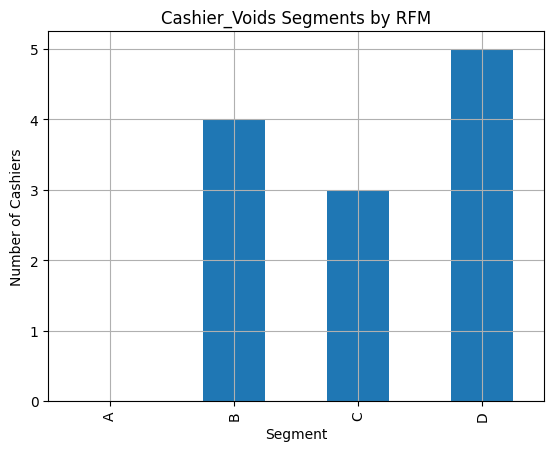

In [17]:
import matplotlib.pyplot as plt

rfm['segment'].value_counts().reindex(['A','B','C','D']).plot(kind='bar')
plt.title("Cashier_Voids Segments by RFM")
plt.xlabel("Segment")
plt.ylabel("Number of Cashiers")
plt.grid(True)
plt.show()

### RFM 2  I think we need to save the orginal rfm out then get the last period df and then compare it to this one to see if anyone has changed behaviors... then we are going to ask chatgpt to help out with what it thinks

In [18]:
a_scale = rfm[rfm['segment']== 'A']
b_scale = rfm[rfm['segment']== 'B']
c_scale = rfm[rfm['segment']== 'C']
d_scale = rfm[rfm['segment']== 'D']

In [19]:
query2 = f"""
select cashier_number, sale_date, sum(total_sales) as sales
    from sales
    where store_number='440'
    and sale_type in ('{type}')
    and sale_date between '{prev_start}' and '{prev_end}'
group by cashier_number, sale_date
order by sale_date

"""

In [20]:
ds2 = pd.read_sql(query2, engine)

2025-06-20 15:34:09,532 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-06-20 15:34:09,533 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2025-06-20 15:34:09,535 INFO sqlalchemy.engine.Engine [cached since 3.684s ago] {'table_name': "\nselect cashier_number, sale_date, sum(total_sales) as sales\n    from sales\n    where store_number='440'\n    and sale_type in ('Refunded')\n    and sale_date between '5/21/2025' and '6/03/2025'\ngroup by cashier_number, sale_date\norder by sale_date\n\n", 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspnam

In [21]:
ds2.head(10)

,cashier_number,sale_date,sales
0,18,2025-05-21,-4.84
1,32,2025-05-21,-5.99
2,70,2025-05-22,-12.58
3,102,2025-05-23,-5.99
4,44,2025-05-24,-2.99
5,97,2025-05-24,-48.65
6,95,2025-05-25,-75.47
7,44,2025-05-26,-29.94
8,102,2025-05-26,-4.99
9,24,2025-05-27,-19.89


In [22]:
ds.head(10)

,cashier_number,sale_date,sales
0,18,2025-06-04,-22.55
1,18,2025-06-05,-10.70
2,44,2025-06-05,-26.99
3,24,2025-06-06,-17.98
4,26,2025-06-06,-2.49
5,102,2025-06-06,-133.42
6,20,2025-06-07,-3.49
7,25,2025-06-08,-29.06
8,37,2025-06-08,-12.99
9,18,2025-06-09,-346.97


In [23]:
print(ds2.shape[0])

24


In [24]:
print(ds.shape[0])

26


### RFM 2 for previous period

In [25]:
today2 = pd.to_datetime('6/12/2025')

rfm2 = ds2.groupby('cashier_number').agg(
    {
        'sale_date': lambda e: (today2 - e.max()).days,
        'cashier_number': 'count',
        'sales': 'sum'
    }
)

In [26]:
rfm2.head(10)

,sale_date,cashier_number,sales
cashier_number,,,
18,22,1,-4.84
20,9,1,-30.37
24,12,2,-54.88
25,11,1,-10.00
26,11,1,-10.99
27,13,2,-38.89
32,22,1,-5.99
35,15,1,-19.98
37,12,2,-108.43


In [27]:
rfm2.columns = ['recency', 'frequency', 'monetary']

In [28]:
rfm2.describe()

,recency,frequency,monetary
count,15.000000,15.000000,15.000000
mean,14.066667,1.600000,-45.932000
std,4.283968,0.828079,51.640999
min,9.000000,1.000000,-193.570000
25%,11.000000,1.000000,-65.175000
50%,13.000000,1.000000,-30.370000
75%,17.000000,2.000000,-10.630000
max,22.000000,4.000000,-4.840000


In [29]:
rfm.describe()

,recency,frequency,monetary,rfm_score,rfm_percent
count,12.000000,12.000000,12.000000,12.000000,12.000000
mean,4.583333,2.166667,-89.021667,7.500000,62.500000
std,4.501683,1.749459,144.672268,1.783765,14.864710
min,0.000000,1.000000,-514.410000,4.000000,33.333333
25%,1.750000,1.000000,-104.335000,6.750000,56.250000
50%,3.500000,1.500000,-21.580000,8.000000,66.666667
75%,5.750000,3.000000,-12.475000,9.000000,75.000000
max,12.000000,7.000000,-3.490000,10.000000,83.333333


In [30]:
rfm2['r_score'] = pd.qcut(rfm2['recency'], 4, labels=[4,3,2,1])
rfm2['f_score'] = pd.qcut(rfm2['frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm2['m_score'] = pd.qcut(rfm2['monetary'],4, labels=[1,2,3,4])

rfm2['rfm_segment'] = rfm2['r_score'].astype(str) + rfm2['f_score'].astype(str) + rfm2['m_score'].astype(str)
rfm2['rfm_score'] = rfm2[['r_score', 'f_score', 'm_score']].astype(int).sum(axis=1)
rfm2['rfm_percent'] = (rfm2['rfm_score'].astype(int)/12) *100

In [31]:
rfm2.sort_values(['rfm_percent'], ascending= False)

,recency,frequency,monetary,r_score,f_score,m_score,rfm_segment,rfm_score,rfm_percent
cashier_number,,,,,,,,,
75,10,1,-10.28,4,2,4,424,10,83.333333
70,9,4,-81.38,4,4,1,441,9,75.000000
25,11,1,-10.00,4,1,4,414,9,75.000000
102,17,2,-10.98,2,4,3,243,9,75.000000
27,13,2,-38.89,3,3,2,332,8,66.666667
26,11,1,-10.99,4,1,3,413,8,66.666667
24,12,2,-54.88,3,3,2,332,8,66.666667
97,13,2,-193.57,3,4,1,341,8,66.666667
44,17,2,-32.93,2,4,2,242,8,66.666667


In [32]:
rfm.sort_values(['rfm_percent'], ascending= False)

,recency,frequency,monetary,r_score,f_score,m_score,rfm_segment,rfm_score,rfm_percent,segment
cashier_number,,,,,,,,,,
32,0,3,-25.18,4,4,2,442,10,83.333333,B
18,0,7,-514.41,4,4,1,441,9,75.000000,B
97,3,1,-10.99,3,2,4,324,9,75.000000,B
19,1,1,-4.04,4,1,4,414,9,75.000000,B
44,4,3,-69.97,2,4,2,242,8,66.666667,C
25,2,3,-94.64,3,3,2,332,8,66.666667,C
26,4,2,-12.97,2,3,3,233,8,66.666667,C
37,2,2,-165.99,3,3,1,331,7,58.333333,D
70,4,1,-15.18,2,2,3,223,7,58.333333,D


In [33]:
def segment_customer2(row):
    if row['rfm_percent'] >= 85:
        return 'A'
    elif 84 >= row['rfm_percent'] >= 75:
        return 'B'
    elif 74 >= row['rfm_percent'] >= 65:
        return 'C'
    elif 64 >= row['rfm_percent']:
        return 'D'
    else:
        return 'NA'

In [34]:
rfm2['segment'] = rfm2.apply(segment_customer2, axis=1)
rfm2['segment'].value_counts().reindex(['A','B','C','D'])

segment
A    NaN
B    4.0
C    5.0
D    6.0
Name: count, dtype: float64

In [35]:

rfm['segment'].value_counts().reindex(['A','B','C','D'])

segment
A    NaN
B    4.0
C    3.0
D    5.0
Name: count, dtype: float64

In [36]:
prev_a_scale = rfm2[rfm2['segment']== 'A']
prev_b_scale = rfm2[rfm2['segment']== 'B']
prev_c_scale = rfm2[rfm2['segment']== 'C']
prev_d_scale = rfm2[rfm2['segment']== 'D']

prev_b_scale.head(10)

,recency,frequency,monetary,r_score,f_score,m_score,rfm_segment,rfm_score,rfm_percent,segment
cashier_number,,,,,,,,,,
25,11,1,-10.00,4,1,4,414,9,75.000000,B
70,9,4,-81.38,4,4,1,441,9,75.000000,B
75,10,1,-10.28,4,2,4,424,10,83.333333,B
102,17,2,-10.98,2,4,3,243,9,75.000000,B


In [37]:
b_scale.head(10)

,recency,frequency,monetary,r_score,f_score,m_score,rfm_segment,rfm_score,rfm_percent,segment
cashier_number,,,,,,,,,,
18,0,7,-514.41,4,4,1,441,9,75.000000,B
19,1,1,-4.04,4,1,4,414,9,75.000000,B
32,0,3,-25.18,4,4,2,442,10,83.333333,B
97,3,1,-10.99,3,2,4,324,9,75.000000,B


In [38]:
prev_c_scale.head()

,recency,frequency,monetary,r_score,f_score,m_score,rfm_segment,rfm_score,rfm_percent,segment
cashier_number,,,,,,,,,,
24,12,2,-54.88,3,3,2,332,8,66.666667,C
26,11,1,-10.99,4,1,3,413,8,66.666667,C
27,13,2,-38.89,3,3,2,332,8,66.666667,C
44,17,2,-32.93,2,4,2,242,8,66.666667,C
97,13,2,-193.57,3,4,1,341,8,66.666667,C


In [39]:
c_scale.head()

,recency,frequency,monetary,r_score,f_score,m_score,rfm_segment,rfm_score,rfm_percent,segment
cashier_number,,,,,,,,,,
25,2,3,-94.64,3,3,2,332,8,66.666667,C
26,4,2,-12.97,2,3,3,233,8,66.666667,C
44,4,3,-69.97,2,4,2,242,8,66.666667,C


In [42]:
prev_d_scale.head()

,recency,frequency,monetary,r_score,f_score,m_score,rfm_segment,rfm_score,rfm_percent,segment
cashier_number,,,,,,,,,,
18,22,1,-4.84,1,1,4,114,6,50.000000,D
20,9,1,-30.37,4,1,2,412,7,58.333333,D
32,22,1,-5.99,1,2,4,124,7,58.333333,D
35,15,1,-19.98,2,2,3,223,7,58.333333,D
37,12,2,-108.43,3,3,1,331,7,58.333333,D


### Now lets merge these and see whats up

In [43]:
mdf = rfm.merge(rfm2, on='cashier_number', suffixes=('_r','_r2'))

In [46]:
mdf['transistion'] = mdf['segment_r'] + '-' + mdf['segment_r2']

In [48]:
mdf.head(30)

,recency_r,frequency_r,monetary_r,r_score_r,f_score_r,m_score_r,rfm_segment_r,rfm_score_r,rfm_percent_r,segment_r,...,frequency_r2,monetary_r2,r_score_r2,f_score_r2,m_score_r2,rfm_segment_r2,rfm_score_r2,rfm_percent_r2,segment_r2,transistion
cashier_number,,,,,,,,,,,,,,,,,,,,,
18,0,7,-514.41,4,4,1,441,9,75.000000,B,...,1,-4.84,1,1,4,114,6,50.000000,D,B-D
20,11,1,-3.49,1,1,4,114,6,50.000000,D,...,1,-30.37,4,1,2,412,7,58.333333,D,D-D
24,12,1,-17.98,1,1,3,113,5,41.666667,D,...,2,-54.88,3,3,2,332,8,66.666667,C,D-C
25,2,3,-94.64,3,3,2,332,8,66.666667,C,...,1,-10.00,4,1,4,414,9,75.000000,B,C-B
26,4,2,-12.97,2,3,3,233,8,66.666667,C,...,1,-10.99,4,1,3,413,8,66.666667,C,C-C
32,0,3,-25.18,4,4,2,442,10,83.333333,B,...,1,-5.99,1,2,4,124,7,58.333333,D,B-D
37,2,2,-165.99,3,3,1,331,7,58.333333,D,...,2,-108.43,3,3,1,331,7,58.333333,D,D-D
44,4,3,-69.97,2,4,2,242,8,66.666667,C,...,2,-32.93,2,4,2,242,8,66.666667,C,C-C
70,4,1,-15.18,2,2,3,223,7,58.333333,D,...,4,-81.38,4,4,1,441,9,75.000000,B,D-B


In [49]:
import seaborn as sns

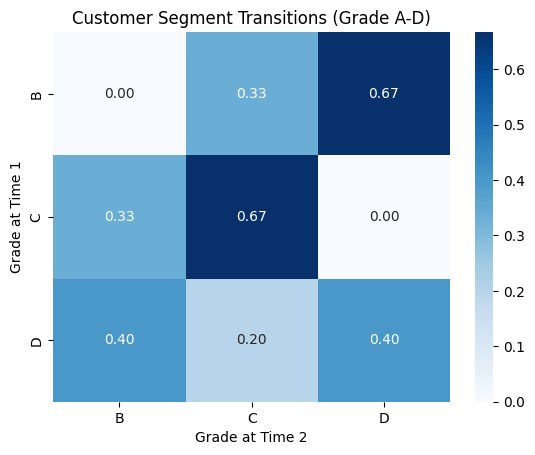

In [50]:
matrix = pd.crosstab(mdf['segment_r'], mdf['segment_r2'], normalize='index')

sns.heatmap(matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title("Customer Segment Transitions (Grade A-D)")
plt.xlabel("Grade at Time 2")
plt.ylabel("Grade at Time 1")
plt.show()